In [1]:
import osmnx as ox, networkx as nx, pandas as pd, geopandas as gpd, time, matplotlib.pyplot as plt, math, ast, re
import statsmodels.api as sm
from geopy.distance import great_circle
from shapely.geometry import Polygon
%matplotlib inline
ox.config(use_cache=True, log_file=True, log_console=True, log_filename='analyze_stats_every_us_urban_area',
          data_folder='G:/Geoff/osmnx/urbanized-areas-usa', cache_folder='G:/Geoff/osmnx/cache')

In [2]:
df = pd.read_csv('usa_stats.csv', encoding='utf-8')

In [3]:
df['city'] = df['name'].map(lambda x: re.findall(r'^[a-z A-Z\s\.]*', x)[0])

In [4]:
df['proportion_streets_per_intersection'] = [ast.literal_eval(p) for p in df['proportion_streets_per_intersection']]

## Plot distribution of intersection types for 9 cities

In [5]:
names = ['Detroit', 'Lubbock', 'Chattanooga', 'Duluth', 'New Orleans', 'Phoenix',
         'Boston', 'Atlanta', 'Chicago']
stats_plot = df[df['city'].isin(names)]
stats_plot = stats_plot.sort_values('area', ascending=False)
stats_plot['city']

1          Atlanta
2          Chicago
4           Boston
8          Detroit
11         Phoenix
67     Chattanooga
80     New Orleans
188        Lubbock
256         Duluth
Name: city, dtype: object

In [6]:
proportion_streets_per_intersection = stats_plot['proportion_streets_per_intersection'].tolist()
names_full = stats_plot['name'].tolist()
names = [re.findall(r'^[a-zA-Z\s]*', name)[0] for name in names_full]

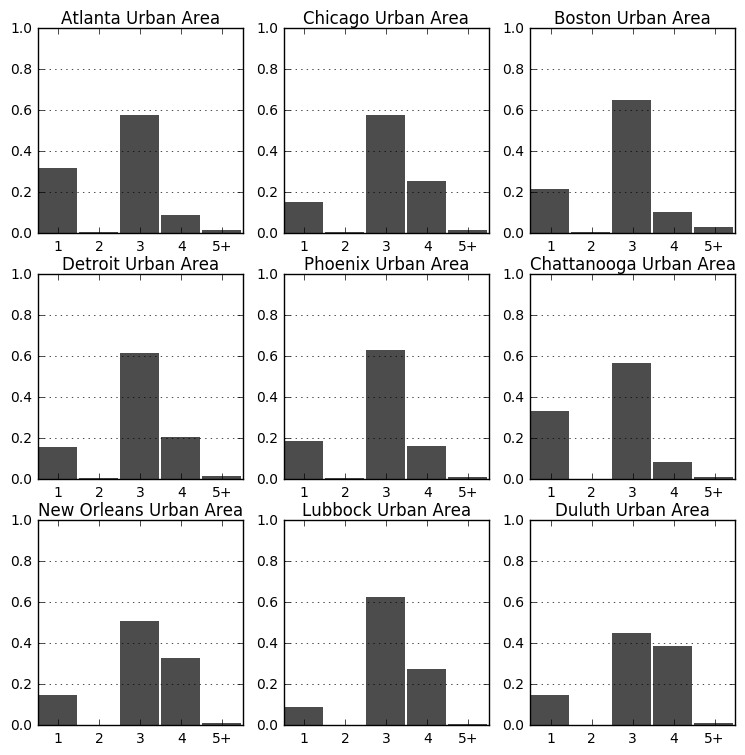

In [7]:
n = len(proportion_streets_per_intersection)
cols = 3
rows = int(n / cols)
max_value = 4
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
for i, (prop, name) in enumerate(zip(proportion_streets_per_intersection, names)):
    
    row = math.floor(i / cols)
    col = i % cols
    ax = axes[row][col]
    
    all_others = sum(list(prop.values())[max_value + 1:])
    prop = {key:value for key, value in prop.items() if key <= max_value}
    prop[max_value + 1] = all_others
    lefts = [x - 0.5 for x in prop.keys()]
    
    ax.bar(left=lefts, height=prop.values(), width=0.95, alpha=0.7,
           color='k', linewidth=0)
    ax.yaxis.grid(True)
    xticklabels = list(range(0, max_value + 1)) + ['{}+'.format(max_value + 1)]
    ax.set_xticklabels(xticklabels)
    
    ax.set_title('{} Urban Area'.format(name), fontsize=12, y=0.99)
    ax.set_xlim(0.5, max_value + 1.5)
    ax.set_ylim(0, 1)

In [8]:
# which cities have high proportion of cul-de-sacs
prop = df['proportion_streets_per_intersection'].tolist()
df.loc[pd.DataFrame(prop, index=df.index).sort_values(1, ascending=False).head(20).index]['name']

87     Aguadilla--Isabela--San Sebastián, PR Urbanize...
191    San Germán--Cabo Rojo--Sabana Grande, PR Urban...
219                           Arecibo, PR Urbanized Area
357      Florida--Imbéry--Barceloneta, PR Urbanized Area
367                           Midland, MI Urbanized Area
17                           San Juan, PR Urbanized Area
313                          Mayagüez, PR Urbanized Area
343                        Juana Díaz, PR Urbanized Area
236                     Santa Clarita, CA Urbanized Area
354                             Yauco, PR Urbanized Area
226                        Marysville, WA Urbanized Area
297           Westminster--Eldersburg, MD Urbanized Area
335    Lexington Park--California--Chesapeake Ranch E...
398    Kailua (Honolulu County)--Kaneohe, HI Urbanize...
67                    Chattanooga, TN--GA Urbanized Area
143                         Bremerton, WA Urbanized Area
259                         Los Lunas, NM Urbanized Area
96                            C

In [9]:
df.sort_values(by='avg_circuity', ascending=True).head()

,area,avg_circuity,avg_edge_length,avg_street_length,avg_streets_per_intersection,count_street_segments,counts_streets_per_intersection,edge_density_km,geoid,int_0_streets_count,...,m,n,name,node_density_km,proportion_streets_per_intersection,self_loop_proportion,time,total_edge_length,total_street_length,city
318,137141203,1.023909,144.075977,148.588027,3.169984,9736,"{0: 0, 1: 651, 2: 1, 3: 3238, 4: 2320, 5: 18, ...",19810.535721,57007,0,...,18857,6230,"Midland, TX Urbanized Area",45.427631,"{0: 0.0, 1: 0.10449438202247191, 2: 0.00016051...",0.000636,2.832351,2.716841e+06,1.446653e+06,Midland
292,152630919,1.026418,155.653474,157.828293,3.171494,9468,"{0: 0, 1: 531, 2: 4, 3: 3477, 4: 2086, 5: 11, ...",19062.158308,64864,0,...,18692,6111,"Odessa, TX Urbanized Area",40.037759,"{0: 0.0, 1: 0.08689248895434462, 2: 0.00065455...",0.000749,2.504020,2.909475e+06,1.494318e+06,Odessa
188,249860381,1.032750,119.010753,122.132723,3.100505,27651,"{0: 0, 1: 1658, 2: 33, 3: 11289, 4: 4943, 5: 7...",24808.079054,51877,0,...,52084,18019,"Lubbock, TX Urbanized Area",72.116275,"{0: 0.0, 1: 0.09201398523780455, 2: 0.00183140...",0.001056,6.407238,6.198556e+06,3.377092e+06,Lubbock
228,210823472,1.034587,120.616848,122.219069,3.245537,22211,"{0: 0, 1: 1003, 2: 44, 3: 7401, 4: 5332, 5: 50...",24242.545885,1927,0,...,42373,13835,"Amarillo, TX Urbanized Area",65.623623,"{0: 0.0, 1: 0.0724972894831948, 2: 0.003180339...",0.001534,4.927011,5.110898e+06,2.714608e+06,Amarillo
283,160423274,1.035577,194.618996,194.762318,2.860110,4805,"{0: 0, 1: 623, 2: 5, 3: 2095, 4: 724, 5: 18, 6...",11362.450516,90730,0,...,9366,3467,"Vineland, NJ Urbanized Area",21.611577,"{0: 0.0, 1: 0.17969426016729162, 2: 0.00144216...",0.002776,1.500012,1.822802e+06,9.358329e+05,Vineland


In [10]:
# filter df for outliers in some column
#col = 'node_count'
stats_plot = df#[df[col] < 100000]
print('Threw out {} greatest {} outliers'.format(len(df)-len(stats_plot), col))

Threw out 0 greatest 2 outliers


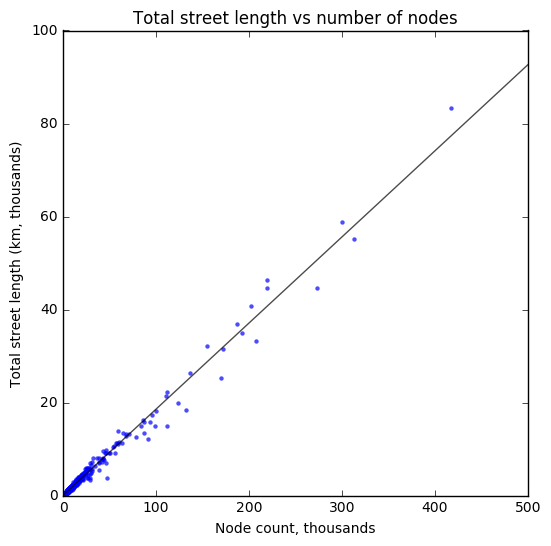

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
x = stats_plot['n'] / 1000
y = stats_plot['total_street_length'] / 1000 / 1000

xlim = [0, math.ceil(x.max()/100)*100] #round to nearest greater 100
ylim = [0, math.ceil(y.max()/20)*20] #round to nearest greater 20

# regress y on x
results = sm.OLS(y, sm.add_constant(x)).fit()

# calculate estimated y values for regression line
x_line = pd.Series(xlim)
y_est = x_line * results.params[1] + results.params[0]

# draw regression line and scatter plot the points
ax.plot(x_line, y_est, c='k', alpha=0.7, linewidth=1, zorder=1)
ax.scatter(x=x, y=y, c='b', linewidths=0, alpha=0.7, s=10)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
#ax.set_xlim((0,15000))
#ax.set_ylim((0,3000))

ax.set_title('Total street length vs number of nodes')
ax.set_xlabel('Node count, thousands')
ax.set_ylabel('Total street length (km, thousands)')

fig.savefig(filename='images/usa-ua-street-length-vs-nodes', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
print(results.rsquared)
results.params

0.984372685935


const    0.066979
n        0.185238
dtype: float64

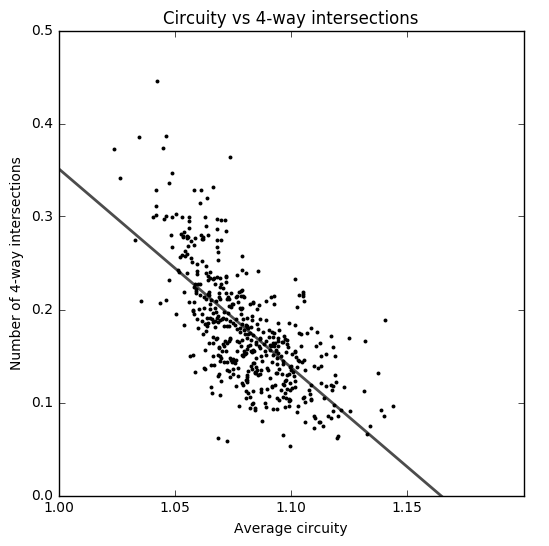

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
x = stats_plot['avg_circuity']
y = stats_plot['int_4_streets_prop']

xlim = (1,1.2)
ylim = (0,0.5)

# regress y on x
results = sm.OLS(y, sm.add_constant(x)).fit()

# calculate estimated y values for regression line
x_line = pd.Series(xlim)
y_est = x_line * results.params[1] + results.params[0]

# draw regression line and scatter plot the points
ax.plot(x_line, y_est, c='k', alpha=0.7, linewidth=2, zorder=1)
ax.scatter(x=x, y=y, c='k', linewidths=0, alpha=1, s=8)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title('Circuity vs 4-way intersections')
ax.set_xlabel('Average circuity')
ax.set_ylabel('Number of 4-way intersections')

fig.savefig(filename='images/usa-ua-circuity-vs-k4', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
print(results.rsquared)
results.params

0.472747439009


const           2.489652
avg_circuity   -2.138232
dtype: float64